In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../Data/SalesData.csv')
sales_data.head()

# one hot encode the categories
categories_onehot = pd.get_dummies(sales_data['Category'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded1 = pd.concat([sales_data, categories_onehot], axis=1)

pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data_encoded1, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Dermafiller,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London,0,...,0,0,1,0,0,0,0,0,0,0
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London,0,...,0,0,1,0,0,0,0,0,0,0
2,1-11-2015,11,4,2015,1,Injection 1,Dermafiller,Pharmacy 2,Outside London M25,1,...,0,0,0,0,0,1,0,0,0,0
3,1-11-2015,11,4,2015,1,Injection 2,Dermafiller,Pharmacy 2,Outside London M25,1,...,0,0,0,0,0,1,0,0,0,0
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68631,1-3-2022,3,1,2022,2,Facemask,Skincare,Pharmacy 5,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
68632,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
68633,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,London,0,...,0,0,1,0,0,0,0,0,0,0
68634,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,London,0,...,0,0,1,0,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Dermafiller',
 'Mesotherapy',
 'Needles',
 'Profilho',
 'Skinbooster',
 'Skincare',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 11',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 6',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Cream 1',
 'Cream 2',
 'Cream 3',
 'Cream 4',
 'Facemask',
 'Foundation 1',
 'Foundation 2',
 'Injection 1',
 'Injection 10',
 'Injection 11',
 'Injection 12',
 'Injection 13',
 'Injection 14',
 'Injection 2',
 'Injection 3',
 'Injection 4',
 'Injection 5',
 'Injection 6',
 'Injection 7',
 'Injection 8',
 'Injection 9',
 'Make-up Remover',
 'Mesotherapy Needles',
 'Pills',
 'Skin Booster Needles',
 'sunblock',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Dermafiller': 'sum',
    'Mesotherapy': 'sum',
    'Needles': 'sum',
    'Profilho': 'sum',
    'Skinbooster': 'sum',
    'Skincare' : 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    'Injection 1' :'sum',
    'Injection 2' :'sum',
    'Injection 3' :'sum',
    'Injection 4' :'sum',
    'Injection 5' :'sum',
    'Injection 6' :'sum',
    'Injection 7' :'sum',
    'Injection 8' :'sum',
    'Injection 9' :'sum',
    'Injection 10' :'sum',
    'Injection 11' :'sum',
    'Injection 12' :'sum',
    'Injection 13' :'sum',
    'Injection 14' :'sum',
    'Cream 1' : 'sum',
    'Cream 2' : 'sum',
    'Cream 3' : 'sum',
    'Cream 4' : 'sum',
    'Facemask' : 'sum',
    'Foundation 1' : 'sum',
    'Foundation 2' : 'sum',
    'Make-up Remover' : 'sum',
    'Mesotherapy Needles' : 'sum',
    'Pills' : 'sum',
    'Skin Booster Needles' : 'sum',
    'sunblock' : 'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

#print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)


# split the data into training and testing sets
train_size = int(len(sales_data_lagged) * 0.8)
train_data = sales_data_lagged[:train_size]
test_data = sales_data_lagged[train_size:]


In [4]:
# train an mlp classifier

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']

random_grid_mlpr = {
    'activation' : activation,
    'solver' : solver
}

# mlpr = MLPRegressor()
# mlpr_random = RandomizedSearchCV(
#     estimator=mlpr,
#     param_distributions=random_grid_mlpr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )
mlpr = MLPRegressor()
mlpr_random = GridSearchCV(
    estimator=mlpr,
    param_grid=random_grid_mlpr,
    cv=5,
    verbose=5
)

In [5]:
mlpr_random.fit(train_data.iloc[:, 2:], train_data['Qty'])


# make predictions for the test data
predictions = mlpr_random.predict(test_data.iloc[:, 2:])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=identity, solver=lbfgs;, score=0.978 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .activation=identity, solver=lbfgs;, score=0.991 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .activation=identity, solver=lbfgs;, score=0.986 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .activation=identity, solver=lbfgs;, score=0.987 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWar

[CV 5/5] END .activation=identity, solver=lbfgs;, score=0.967 total time=   0.1s
[CV 1/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  re

[CV 2/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 3/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 4/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 5/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ..activation=identity, solver=adam;, score=0.984 total time=   0.0s
[CV 2/5] END ..activation=identity, solver=adam;, score=0.973 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ..activation=identity, solver=adam;, score=0.989 total time=   0.1s
[CV 4/5] END ..activation=identity, solver=adam;, score=0.985 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END ..activation=identity, solver=adam;, score=0.977 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=logistic, solver=lbfgs;, score=0.082 total time=   0.3s
[CV 2/5] END .activation=logistic, solver=lbfgs;, score=0.041 total time=   0.0s
[CV 3/5] END activation=logistic, solver=lbfgs;, score=-0.034 total time=   0.5s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .activation=logistic, solver=lbfgs;, score=0.190 total time=   1.7s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .activation=logistic, solver=lbfgs;, score=0.560 total time=   0.9s
[CV 1/5] END ...activation=logistic, solver=sgd;, score=0.217 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ...activation=logistic, solver=sgd;, score=0.390 total time=   0.0s
[CV 3/5] END ...activation=logistic, solver=sgd;, score=0.136 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ...activation=logistic, solver=sgd;, score=0.121 total time=   0.0s
[CV 5/5] END ...activation=logistic, solver=sgd;, score=0.041 total time=   0.0s
[CV 1/5] END .activation=logistic, solver=adam;, score=-1.758 total time=   0.0s
[CV 2/5] END .activation=logistic, solver=adam;, score=-0.722 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .activation=logistic, solver=adam;, score=-1.433 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .activation=logistic, solver=adam;, score=-0.768 total time=   0.1s
[CV 5/5] END .activation=logistic, solver=adam;, score=-1.086 total time=   0.0s
[CV 1/5] END ....activation=tanh, solver=lbfgs;, score=-0.348 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .....activation=tanh, solver=lbfgs;, score=0.771 total time=   0.3s
[CV 3/5] END .....activation=tanh, solver=lbfgs;, score=0.451 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .....activation=tanh, solver=lbfgs;, score=0.668 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .....activation=tanh, solver=lbfgs;, score=0.643 total time=   0.4s
[CV 1/5] END .......activation=tanh, solver=sgd;, score=0.021 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .......activation=tanh, solver=sgd;, score=0.822 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .......activation=tanh, solver=sgd;, score=0.399 total time=   0.2s
[CV 4/5] END .......activation=tanh, solver=sgd;, score=0.313 total time=   0.0s
[CV 5/5] END .......activation=tanh, solver=sgd;, score=0.577 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .....activation=tanh, solver=adam;, score=-1.758 total time=   0.0s
[CV 2/5] END .....activation=tanh, solver=adam;, score=-0.724 total time=   0.0s
[CV 3/5] END .....activation=tanh, solver=adam;, score=-1.434 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .....activation=tanh, solver=adam;, score=-0.767 total time=   0.0s
[CV 5/5] END .....activation=tanh, solver=adam;, score=-1.086 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .....activation=relu, solver=lbfgs;, score=0.976 total time=   0.1s
[CV 2/5] END .....activation=relu, solver=lbfgs;, score=0.977 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .....activation=relu, solver=lbfgs;, score=0.993 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .....activation=relu, solver=lbfgs;, score=0.944 total time=   0.1s
[CV 5/5] END .....activation=relu, solver=lbfgs;, score=0.996 total time=   0.1s
[CV 1/5] END activation=relu, solver=sgd;, score=-71217156102476064.000 total time=   0.0s
[CV 2/5] END activation=relu, solver=sgd;, score=-45784288139214392.000 total time=   0.0s
[CV 3/5] END activation=relu, solver=sgd;, score=-211846280980898359827003415555862135436321462477763354723384033280.000 total time=   0.0s
[CV 4/5] END activation=relu, solver=sgd;, score=-12280108184041808.000 total time=   0.0s
[CV 5/5] END activation=relu, solver=sgd;, score=-74676577988968041594182425463982499066925865809353068531700203520.000 total time=   0.0s
[CV 1/5] END ......activation=relu, solver=adam;, score=0.814 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ......activation=relu, solver=adam;, score=0.947 total time=   0.0s
[CV 3/5] END ......activation=relu, solver=adam;, score=0.939 total time=   0.0s
[CV 4/5] END ......activation=relu, solver=adam;, score=0.842 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\g

[CV 5/5] END ......activation=relu, solver=adam;, score=0.976 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [6]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - test_data['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(test_data['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(test_data['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(test_data['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(test_data['Qty'], predictions)
print('Max Error:', max_error)


print([test_data['Date'].values, test_data['Qty'].values, predictions])

RMSE: 570.8439457951029
MSE: 325862.8104509223
R^2 Score: 0.9824223270511453
Explained Variance Score: 0.9839770767098187
Max Error: 1582.8839299080737
[array(['1-7-2020', '1-7-2021', '1-8-2016', '1-8-2017', '1-8-2018',
       '1-8-2019', '1-8-2020', '1-8-2021', '1-9-2016', '1-9-2017',
       '1-9-2018', '1-9-2019', '1-9-2020', '1-9-2021'], dtype=object), array([ 9580, 12427,   419,  1470,  3981,  4878,  8849, 11775,   688,
        1234,  4642,  6613, 10034, 12261], dtype=int64), array([ 7997.11607009, 11784.54827516,   535.01723486,  1517.6712124 ,
        4000.76412926,  5090.24720174,  8371.80364988, 12186.34094268,
         580.05818768,  1596.50490753,  4199.36000396,  6410.64602033,
        9355.4453919 , 12848.66395789])]


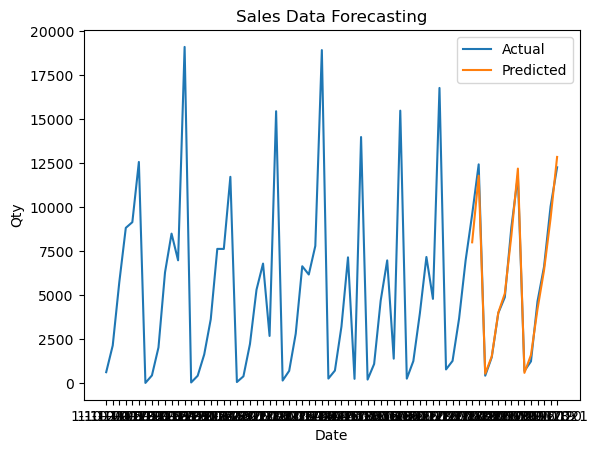

In [7]:
sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=test_data.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [8]:
mlpr_random.best_params_

{'activation': 'identity', 'solver': 'lbfgs'}

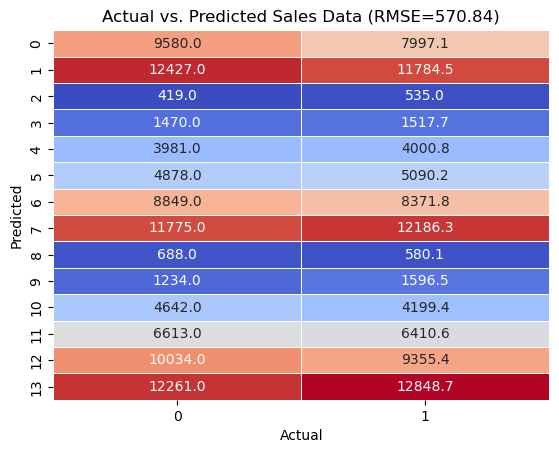

In [9]:
matrix_data = np.column_stack((test_data['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()